In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import kstest, norm
from scipy.stats import ks_2samp
import lime.lime_tabular
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
import shap
shap.initjs()
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Reading Dataset

In [2]:
airbnb_df=pd.read_csv('AB_NYC_2019.csv')

In [3]:
airbnb_df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [4]:
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Processing and EDA

## Filling in missing Data

There are a lot of missing data such as NaN for "last_review" and "reviews_per_month" which could cause trouble with many machine learning algorithms. Not only that, there are multiple missing values in the data.

In [5]:
total = airbnb_df.isnull().sum().sort_values(ascending=False)
percent = (airbnb_df.isnull().sum())/airbnb_df.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
last_review,10052,0.205583
reviews_per_month,10052,0.205583
host_name,21,0.000429
name,16,0.000327
id,0,0.000000
host_id,0,0.000000
neighbourhood_group,0,0.000000
neighbourhood,0,0.000000
latitude,0,0.000000
longitude,0,0.000000


We drop the those that are missing entry in 'host_name' and 'name' and replace NaN in 'last_review' and 'reviews_per_month' with '0'.

In [6]:
airbnb_df.drop(['host_name', 'name'], axis=1, inplace=True)

In [7]:
airbnb_df[airbnb_df['number_of_reviews']==0.0].shape

(10052, 14)

In [8]:
airbnb_df['reviews_per_month'] = airbnb_df['reviews_per_month'].fillna(0)

For 'last_review', as those listings without reviews are filled with NaN, it is replaced with earliest review dates and converts the date to ordinal representation (single integer, representing the no. of days from Jan1 of year 1) then subtracts the ordinal value of the earliest review date from each of these ordinal values.

In [9]:
airbnb_df['last_review'] = pd.to_datetime(airbnb_df['last_review'],infer_datetime_format=True) 
earliest = min(airbnb_df['last_review'])
airbnb_df['last_review'] = airbnb_df['last_review'].fillna(earliest)
airbnb_df['last_review'] = airbnb_df['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [10]:
total = airbnb_df.isnull().sum().sort_values(ascending=False)
percent = (airbnb_df.isnull().sum())/airbnb_df.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
id,0,0.0
host_id,0,0.0
neighbourhood_group,0,0.0
neighbourhood,0,0.0
latitude,0,0.0
longitude,0,0.0
room_type,0,0.0
price,0,0.0
minimum_nights,0,0.0
number_of_reviews,0,0.0


Data is now cleaned and there is no empty entries in the dataset

## Price distribution

As price seems very skewed, 3 separate graphs are plotted, original data, log transformed graph and Q-Q plot to assess the normality of the log-transformed price data

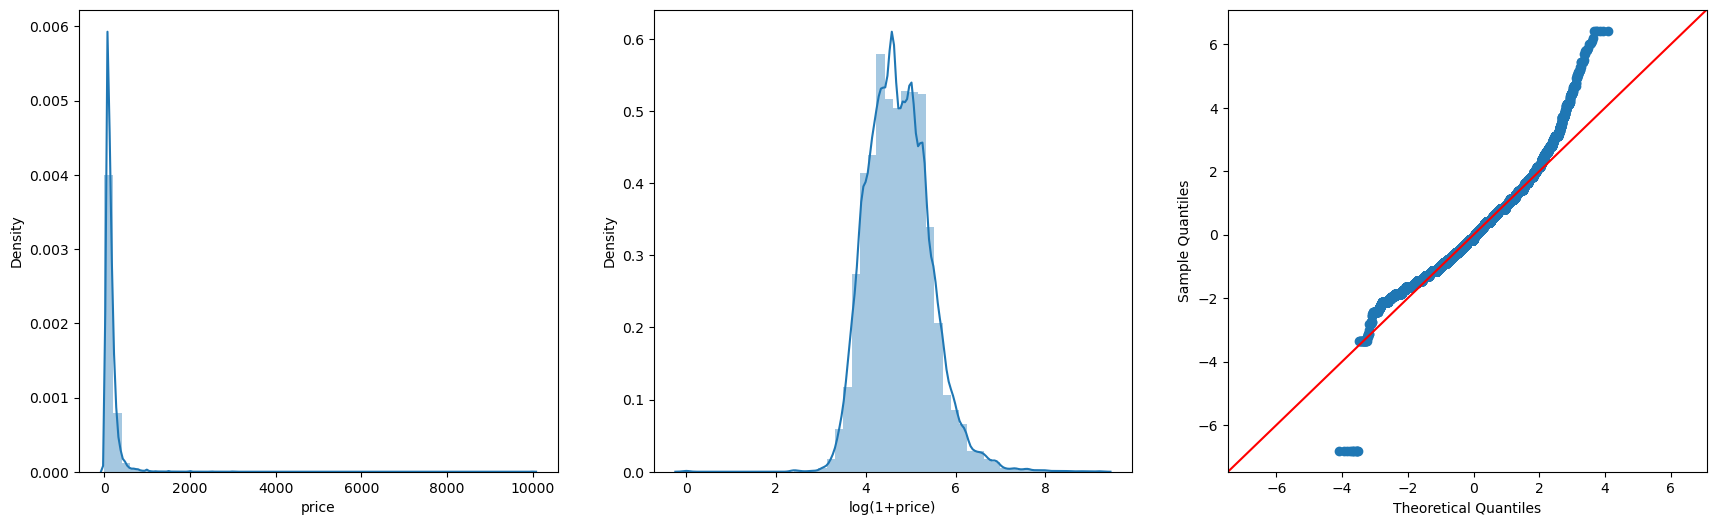

In [11]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(airbnb_df['price'], ax=axes[0])
sns.distplot(np.log1p(airbnb_df['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(airbnb_df['price']), stats.norm, fit=True, line='45', ax=axes[2]);

from Q-Q graph, the data looks skewed, Shapiro wilks test is performed to check the skewness of the data

In [12]:
stat, p = shapiro(airbnb_df['price'])
print('Shapiro-Wilk Test Statistic=%.3f, p-value=%.3f' % (stat, p))

Shapiro-Wilk Test Statistic=0.300, p-value=0.000


Shapiro is not very good for large sample size, so instead, we use K-S test

In [13]:
data = airbnb_df['price']
mean = np.mean(data)
std = np.std(data, ddof=1)
stat, p = kstest(data, 'norm', args=(mean, std))
print(f'K-S Test Statistic={stat:.3f}, p-value={p:.3f}')

K-S Test Statistic=0.296, p-value=0.000


As both Shapiro and K-S tests give p-value < 0.05, we can conclude that it does not follow normal distribution

In [14]:
airbnb_df['price'] = np.log1p(airbnb_df['price'])

# Predictor distributions

## List of Predictors

In [15]:
print(airbnb_df.columns)

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


'id', 'host_id' are not likely to play a part in the prediction, hence those are dropped

In [16]:
airbnb_df = airbnb_df.drop(['host_id', 'id'], axis=1)

## Neighbourhood Group

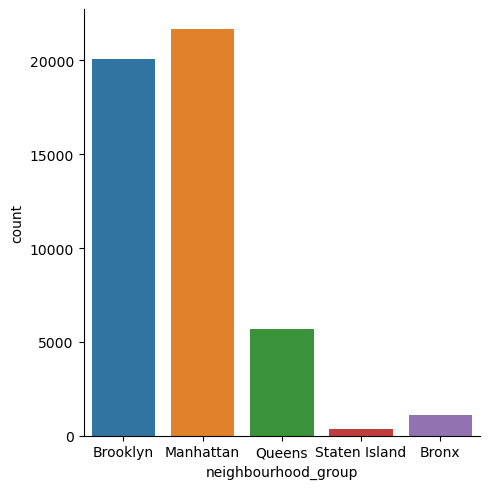

In [17]:
sns.catplot(x='neighbourhood_group', kind='count', data=airbnb_df)
fig = plt.gcf()

Brooklyn and Manhattan show lots of listings as they are popular tourist attraction. Staten Island on the other hand, show little listings as the island is small. However, listings of Bronx seem a bit low

<Axes: xlabel='longitude', ylabel='latitude'>

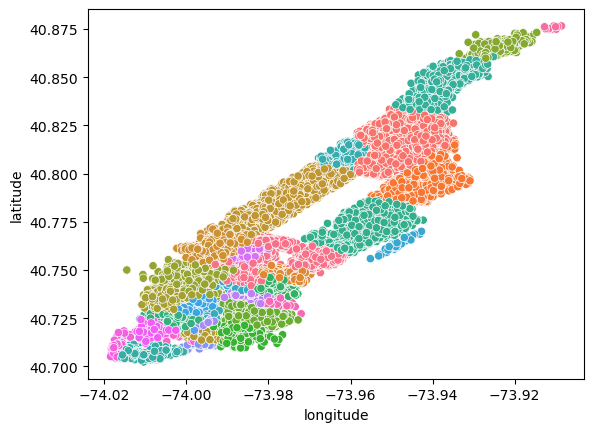

In [18]:
sns.scatterplot(data=airbnb_df[airbnb_df['neighbourhood_group']=='Manhattan'], x='longitude', y='latitude', hue='neighbourhood',legend=False)

Cool

## Longitude and Lattiude

<Axes: xlabel='latitude', ylabel='longitude'>

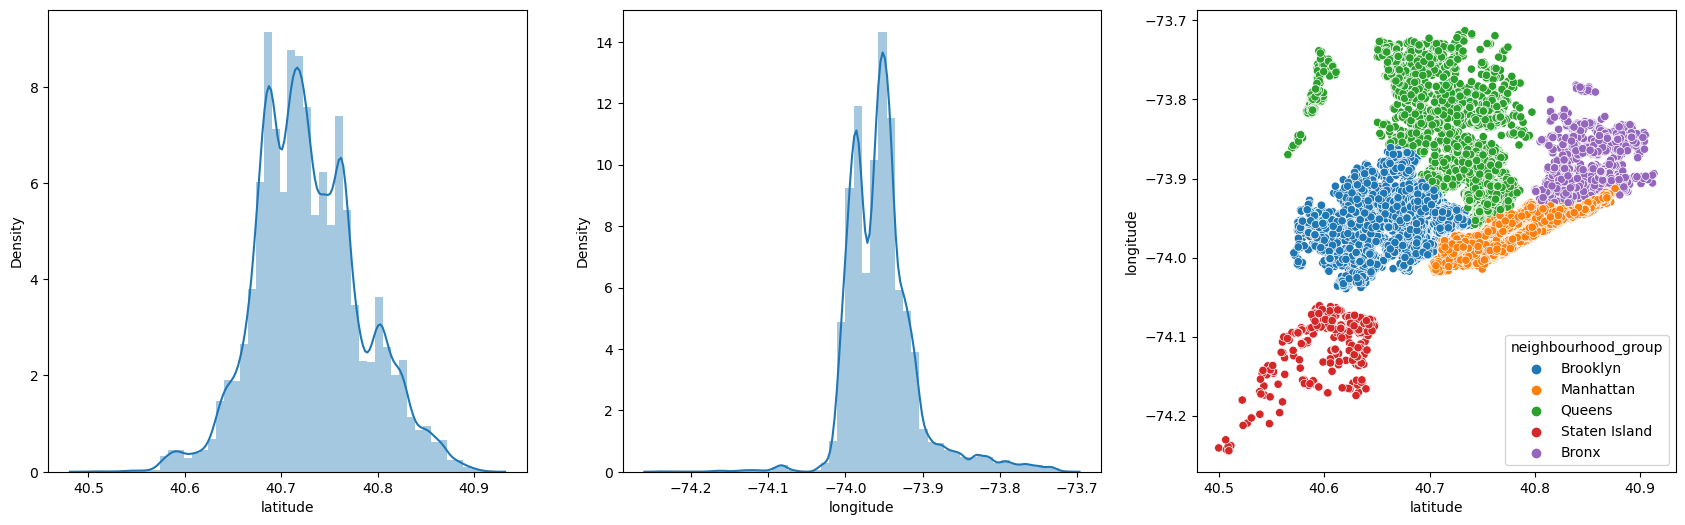

In [19]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(airbnb_df['latitude'], ax=axes[0])
sns.distplot(airbnb_df['longitude'], ax=axes[1])
sns.scatterplot(x= airbnb_df['latitude'], y=airbnb_df['longitude'], hue=airbnb_df['neighbourhood_group'])

## Room Type

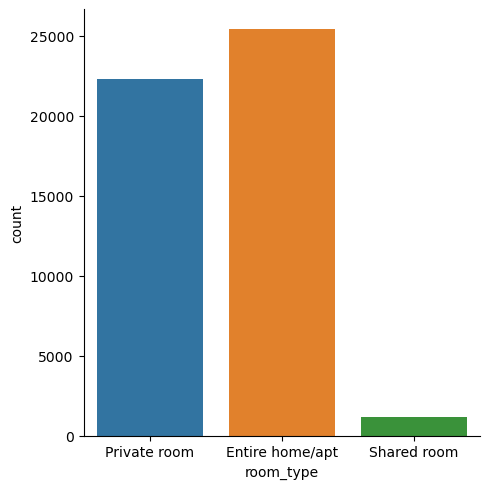

In [20]:
sns.catplot(x='room_type', kind='count' ,data=airbnb_df)
fig = plt.gcf()

As seen from graph, there is not enough representation of Shared Room in the dataset. This could lead to 'shared room' being under-represented in our data analysis.

## Minimum Nights

In [21]:
airbnb_df['minimum_nights'].describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

As minimum_nights have very large max compared to its median, it is likely to be skewed due to the outlier

Text(0, 0.5, 'count')

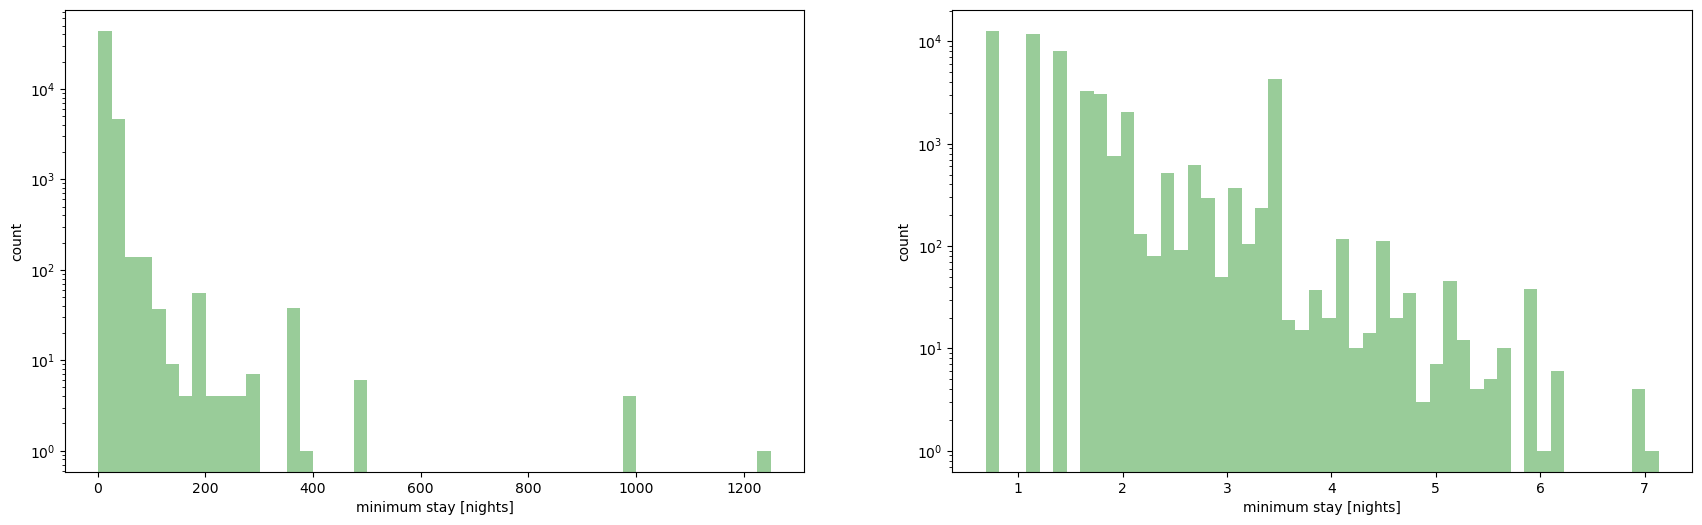

In [22]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(airbnb_df['minimum_nights'], rug=False, kde=False, color="green", ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(airbnb_df['minimum_nights']), rug=False, kde=False, color="green", ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')

Log transformation is performed to bring the scale down to managable level for our models

In [23]:
airbnb_df['minimum_nights'] = np.log1p(airbnb_df['minimum_nights'])

## Reviews per month

Text(0.5, 0, 'ln(reviews_per_month)')

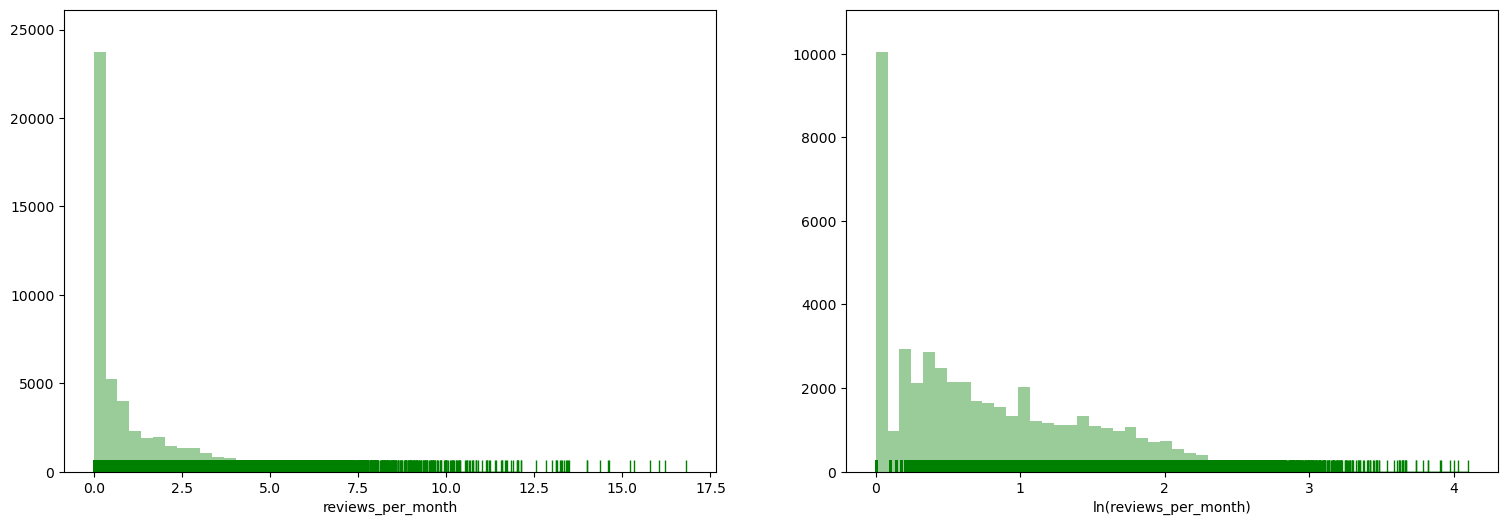

In [24]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))
sns.distplot(airbnb_df[airbnb_df['reviews_per_month'] < 17.5]['reviews_per_month'], rug=True, kde=False, color="green", ax=axes[0])
sns.distplot(np.sqrt(airbnb_df[airbnb_df['reviews_per_month'] < 17.5]['reviews_per_month']), rug=True, kde=False, color="green", ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)')

## Number of Reviews
Number of reviews is likely to be correlated to reviews per month


<Axes: xlabel='number_of_reviews'>

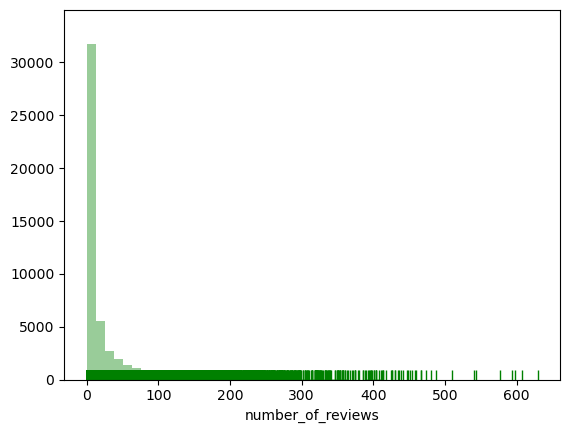

In [25]:
sns.distplot(airbnb_df['number_of_reviews'], rug=True, kde=False, color="green")

It seems highly skewed as there are few listings with large number of reviews while most listings have 0 or 1 review

# Correlation

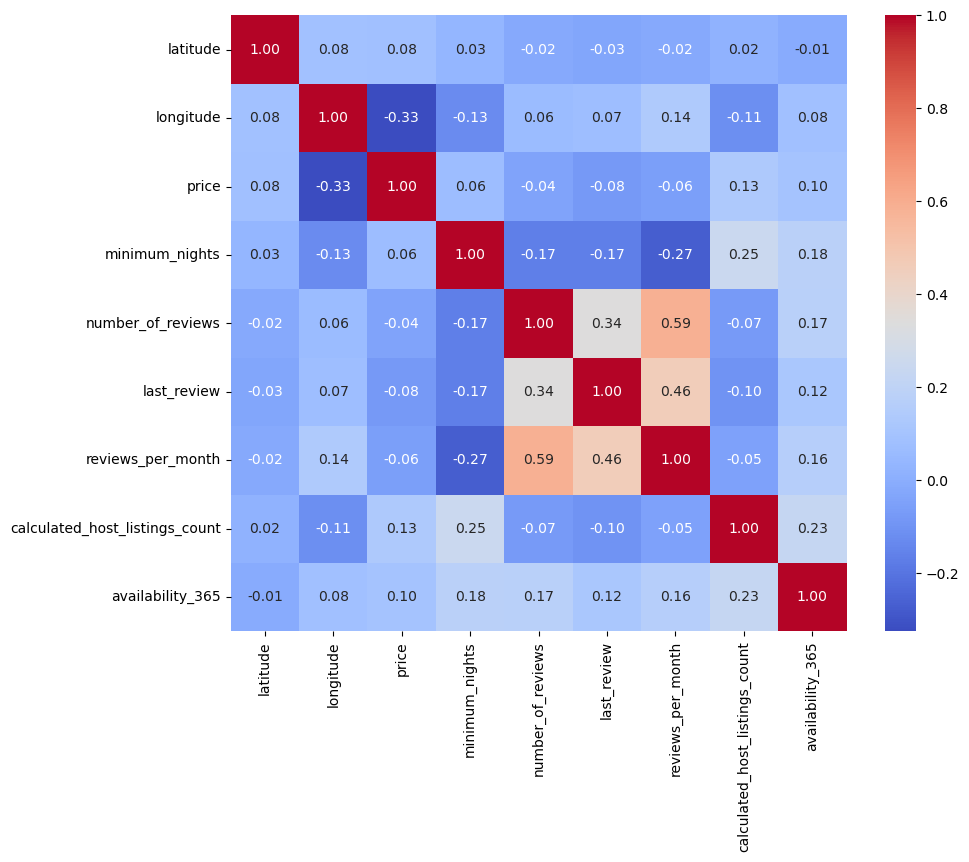

In [26]:
Corr = airbnb_df.corr()
plt.figure(figsize = (10,8))
sns.heatmap(Corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.show()

There does not seem to be strong correlation between price and any other value and the strongest correlation with price comes from longtitude. This seems to be due to the fact that property in Bronx and Queens tend to be cheaper than Manhattan and Brooklyn

Between predictors, the obvious relation comes from number_of_reviews and reviews_per_month.

## Encoding of categorical values

As some of the columns contain categorical strings such as 'neightbourhood_group', 'neighbourhood', 'room_type', they have to be encoded to numerical value for them to be easily interpreted by the machine learning models

In [27]:
airbnb_df['neighbourhood'] = airbnb_df['neighbourhood'].astype('category').cat.codes
airbnb_df['room_type'] = airbnb_df['room_type'].astype('category').cat.codes
airbnb_df['neighbourhood_group'] = airbnb_df['neighbourhood_group'].astype('category').cat.codes
airbnb_df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1,108,40.64749,-73.97237,1,5.010635,0.693147,9,2762,0.21,6,365
1,2,127,40.75362,-73.98377,0,5.420535,0.693147,45,2976,0.38,2,355
2,2,94,40.80902,-73.94190,1,5.017280,1.386294,0,0,0.00,1,365
3,1,41,40.68514,-73.95976,0,4.499810,0.693147,270,3021,4.64,1,194
4,2,61,40.79851,-73.94399,0,4.394449,2.397895,9,2793,0.10,1,0


Creating encode mapping so that we can refer to it later

In [28]:
# For 'neighbourhood'
neighbourhood_mapping = dict(enumerate(airbnb_df['neighbourhood'].astype('category').cat.categories))
# Reverse mapping
neighbourhood_inv_mapping = {v: k for k, v in neighbourhood_mapping.items()}

# For 'room_type'
room_type_mapping = dict(enumerate(airbnb_df['room_type'].astype('category').cat.categories))
# Reverse mapping
room_type_inv_mapping = {v: k for k, v in room_type_mapping.items()}

# For 'neighbourhood_group'
neighbourhood_group_mapping = dict(enumerate(airbnb_df['neighbourhood_group'].astype('category').cat.categories))
# Reverse mapping
neighbourhood_group_inv_mapping = {v: k for k, v in neighbourhood_group_mapping.items()}

In [29]:
encoded_value = 1
original_category = room_type_mapping[encoded_value]
print(f"The encoded value {encoded_value} represents the category '{original_category}'.")

The encoded value 1 represents the category '1'.


## Preparing Train / Test samples

These train/test will be used throughout our models in order to ensure consistency in our testing

In [30]:
X = airbnb_df[['neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']]
y = airbnb_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=20)

In [31]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (39116, 11)
Dimensions of the training target vector: (39116,)
Dimensions of the test feature matrix: (9779, 11)
Dimensions of the test target vector: (9779,)


This is a scaler. This scales the values of predictors for training and test predictors to standardize or normalize predictors. 

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [33]:
X_train

array([[-0.91974729, -0.23468155,  0.03874556, ..., -0.68065951,
         0.77171744,  1.91475695],
       [ 0.43822784, -0.49663856, -0.41732066, ..., -0.00888809,
        -0.18718059, -0.31014701],
       [-0.91974729, -0.4820854 , -1.59494092, ..., -0.19549126,
        -0.15721502, -0.11271525],
       ...,
       [-0.91974729, -0.4820854 , -1.52535593, ...,  3.5365722 ,
        -0.18718059,  1.55026756],
       [ 0.43822784, -0.19102204,  1.53014084, ...,  2.08106745,
        -0.18718059,  0.16824531],
       [-0.91974729, -0.64217024, -1.02540895, ..., -0.68065951,
        -0.18718059,  0.40364471]])

In [34]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(airbnb_df.select_dtypes(exclude=['object']))
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

rmse_cv model for calculating Cross-Validation

# Models

## Aim of the models
Our aim of the models is to 
1. Predict the price of the model based on the variables -> suggested price based on the variables (Price)
2. Deduce if the price of the listing is over the predicted pricing (overpaying) or under the predicted pricing (good deal)

# Linear Regression

In [35]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_y_train = lin_model.predict(X_train)
lin_y_pred = lin_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, lin_y_pred))
coefficients = lin_model.coef_
intercept = lin_model.intercept_

print(f'rmse: {rmse}')
print(f'coeff: {coefficients}')
print(f'intercept: {intercept}')

rmse: 0.5101953781868086
coeff: [ 0.03778801  0.03798226  0.05270685 -0.16890209 -0.40591539 -0.09409661
 -0.02691969 -0.06108621 -0.00680643  0.01420003  0.11770796]
intercept: 4.73624114231095


Using LIME (Local Interpretable Model-agnostic Explanations), we can explain the predictions of a model, interpretting the model's prediction for a single instance from our test set, focusing on the top 5 features that influence the prediction.

In [36]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['price'], verbose=True, mode='regression')

In [37]:
i=25
exp = explainer.explain_instance(X_test[i], lin_model.predict, num_features=5)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], index=X.columns)
item.loc['minimum_nights'] = np.expm1(item.loc['minimum_nights'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
print(f'train_r2_score : {r2_score(y_train, lin_y_train)}')
print(f'test_r2_score : {r2_score(y_test, lin_y_pred)}')
#print(exp.intercept)
#print(exp.local_pred)
item.loc['predicted_price'] = np.exp(exp.local_pred)
item[(item.select_dtypes(include=['number']) != 0).any(1)]


Intercept 4.8277574901494384
Prediction_local [3.93415287]
Right: 4.701597578905665
train_r2_score : 0.47470529190809807
test_r2_score : 0.47706091763922553


,0
neighbourhood_group,1.000000
neighbourhood,30.000000
latitude,40.638160
longitude,-73.914430
minimum_nights,1.000000
number_of_reviews,119.000000
last_review,3023.000000
reviews_per_month,9.130000
calculated_host_listings_count,1.000000
availability_365,61.000000


In [38]:
exp.show_in_notebook(show_table=True)

In [39]:
lin_model.coef_

array([ 0.03778801,  0.03798226,  0.05270685, -0.16890209, -0.40591539,
       -0.09409661, -0.02691969, -0.06108621, -0.00680643,  0.01420003,
        0.11770796])

In [40]:
X.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

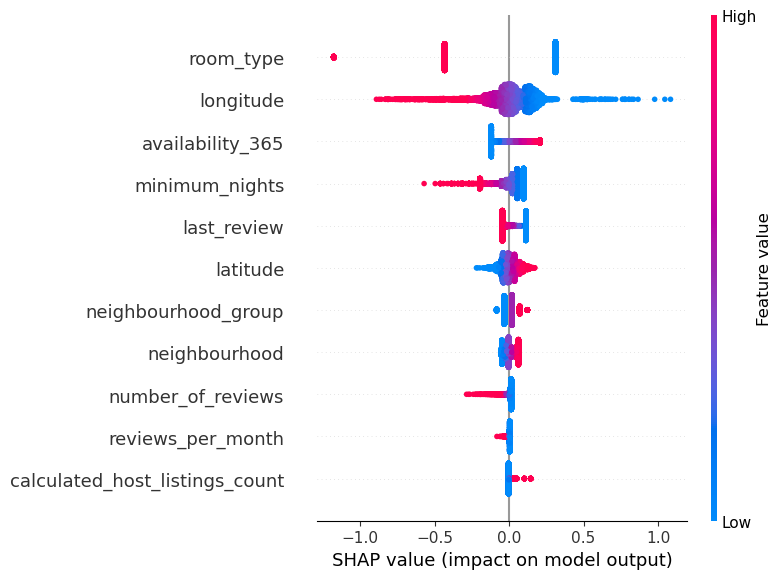

In [41]:
explainer_sh = shap.LinearExplainer(lin_model, X_train, feature_perturbation='interventional')
shap_values = explainer_sh.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

SHAP values quantify the contribution of each predictor for the predictions. 

Magnitude: indicates the strength of the impact of the feature on the model's prediction for a particular observation

Direction: 
Positive SHAP value represents presence of the feature pushes the model's prediction higher
Negative SHAP value suggests that the feature contributes to lowering the features

From the SHAP summary plot above, we can see that 'room_type', 'minimum_nights' and 'longitude' seem to be influential in the model's predictions, with significant variability in their effects.

For 'longitude', both high and low values can have both positive and negative impact on the prediction, suggesting a non-linear relationship.

For 'room_type', depending on which room type it is (Entire home, Private room or Shared room), it pushes the prediction in one direction.

Rest do not have significant SHAP values, indicating they have smaller impact on the lin_model's predictions

In [42]:
lin_CV = -rmse_cv(lin_model)

linear_results = pd.DataFrame({'algorithm':['Linear Regression'],
            'CV error': lin_CV.mean(), 
            'CV std': lin_CV.std(),
            'training error': [mean_squared_error(y_train, lin_y_train)],
            'test error': [mean_squared_error(y_test, lin_y_pred)],
            'training_r2_score': [r2_score(y_train, lin_y_train)],
            'test_r2_score': [r2_score(y_test, lin_y_pred)]})
linear_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Linear Regression,0.252338,0.008777,0.252102,0.260299,0.474705,0.477061


# Ridge Regression Model

Ridge regression model is a technique for analzying multiple regression data that suffer from multicollinearity. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors. It is regularized version of linear regression.

Ridge Regression is able to produce better long-term predictions than OLS and is particularly useful when the number of predictor variables in a set exceeds the numbre of observations.

First we need to find optimal values of alpha using cross-validation.

In [43]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]
alphas2 = [0.5*i for i in range(4,12)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

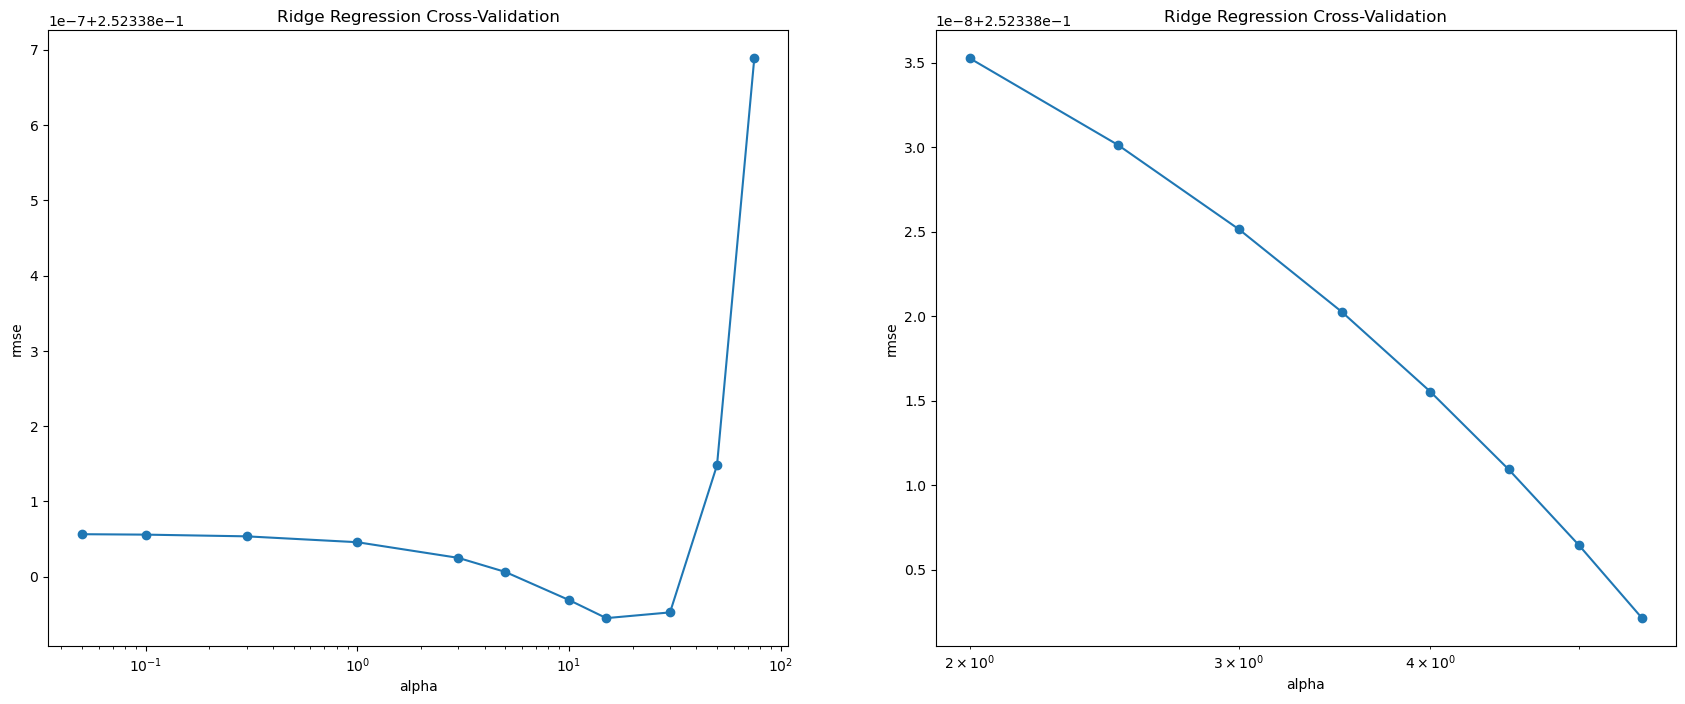

In [44]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots(1,2,figsize=(21, 8))
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[0]) 
axes[0].set_xlabel("alpha") 
axes[0].set_ylabel("rmse")
axes[0].set_xscale('log')

cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[1]) 
axes[1].set_xlabel("alpha") 
axes[1].set_ylabel("rmse")
axes[1].set_xscale('log')

#RR_best = Ridge(alpha = np.argmin(cv_ridge)) RR_best.fit(X_train, y_train) predicted_prices = RR_best.predict(test_data)

we take the alpha value with the minimum mse rmse value

In [45]:
best_alpha = alphas1[np.argmin(cv_ridge2.values)]
RR_CV_best = -rmse_cv(Ridge(alpha = best_alpha))
RR = Ridge(alpha = best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': RR_CV_best.mean(), 
            'CV std': RR_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error': [mean_squared_error(y_test, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,0.252338,0.00878,0.252102,0.260302,0.474705,0.477055


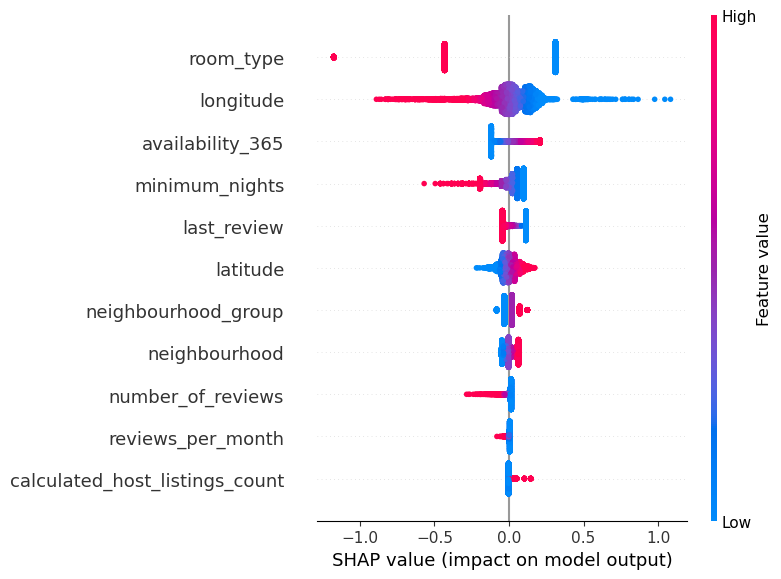

In [46]:
explainer_sh = shap.LinearExplainer(RR, X_train, feature_perturbation='interventional')
shap_values = explainer_sh.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

Same as above, 'room_type', 'minimum_nights' and 'longitude' seem to affect the predictions the most compared to other predictor variables

# Random Forest Regressor

Random Forest Regressor is learning model that fits multiple decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control overfitting.

In [47]:
rf_model = RandomForestRegressor(random_state=20)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
rf_y_train = rf_model.predict(X_train)

In [48]:
rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
rf_model_cv = -rmse_cv(rf_model)
rf_model_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
            'CV error': rf_model_cv.mean(), 
            'CV std': rf_model_cv.std(),
            'training error': [mean_squared_error(rf_y_train, y_train)],
            'test error': [mean_squared_error(rf_y_pred, y_test)]})

In [49]:
rf_model_results

,algorithm,CV error,CV std,training error,test error
0,Random Forest Regressor [baseline],0.195331,0.005555,0.027361,0.204396


In [50]:
# param_grid = {
#     'n_estimators': [1400, 1000, 500, 2000, 3000],
#     'max_depth': [5, 6, 7, 8, 9, 10],
# }
# grid_search = GridSearchCV(estimator=RandomForestRegressor(), 
#                            param_grid=param_grid,
#                            cv=5, 
#                            n_jobs=-1,
#                            verbose=2, 
#                            scoring='neg_root_mean_squared_error')
# grid_search.fit(X_train, y_train)
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

Best parameters: {'max_depth': 10, 'n_estimators': 1400}
Best score: -0.44236161609494723

In [51]:
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

In [53]:
#best_model = grid_search.best_estimator_

We are using Grid Search in order to find the best parameters for Random Forest Regressor

In [54]:
best_model = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=10,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, 
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=1400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
rfr_CV_best = -rmse_cv(best_model)
best_model.fit(X_train, y_train) 
y_train_rfr = best_model.predict(X_train)
y_test_rfr = best_model.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Random Forest Regressor,0.198668,0.007045,0.172,0.208236,0.64161,0.581655


In [55]:
explainer_tree = shap.TreeExplainer(best_random)

NameError: name 'best_random' is not defined

In [ ]:
shap_values = explainer_tree.shap_values(X_test, approximate=True)

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

## Model Conclusion

In [ ]:
pd.concat([linear_results, ridge_results, rfr_best_results], axis=0, ignore_index=True)

Cross-Validation (CV) Error : This measures how well the model is expected to perform on unseen data. Lower the value, the better.

CV Standard Deviation (CV std) : This measures the variability of the model performance across different folds of CV. Lower values indicate more stable performance

Training Error : Reflects how well model fits the training data

Test Error : Represents the model's performance on the test set. Lower the better

R^2 Score : Reflects the proportion of variance in the dependent variable that is predicatable from the independent varaibles, for both training and test sets. Higher R^2 scores are generally better

Linear Regression does not outperform other models but have a very consistent training and test r2 score, showing it has stable generalization capability

Ridge Regression is similar to linear Regression

Random Forest Regressor has the lowest CV error and signifcantly lower training error, indicating strong fit to the training data. However, the test error, even though lower than the others, hints at potential overfitting. Despite this, it still achieves the highest test R2 score, suggesting it explains a more considerable portion of the variance in the test than other models.

Hence, RFR will be chosen to base our predictions on pricing moving forward

# Practical Application
Given our model, we are now able to predict the prices of listings, based on their variables.

We will be now looking at whether a listing is overpriced or underpriced based on their listings, by comparing to our predicted values.

We have two separate comparisons, one without accounting for error in our model and one accounting for the errors in our model

In [ ]:
airbnb_df['Predicted Price'] = best_model.predict(X)

In [ ]:
airbnb_df['Predicted Price'].head()

In [ ]:
airbnb_df['price'].head()

In [ ]:
airbnb_df['Predicted Price'] = np.exp(airbnb_df['Predicted Price'])


In [ ]:
airbnb_df['price'] = np.exp(airbnb_df['price'])

In [ ]:
airbnb_df['price'].head()

In [ ]:
airbnb_df.describe()

In [ ]:
price_df = airbnb_df[['Predicted Price', 'price']]

In [ ]:
price_df.describe()

In [ ]:
price_df.head()

## Range of Fluctuations 
The range of fluctuations of the model's error is indicated by the CV std. To understand this range on the RMSE scale, you would look at the CV error plus or minus one standard deviation:

Lower bound of CV RMSE: 0.195794 - 0.006821 = 0.188973

Upper bound of CV RMSE: 0.195794 + 0.006821 = 0.202615

Range of fluctuations (1 standard deviation from CV RMSE): 0.188973 to 0.202615

In [ ]:
factor = np.exp(0.195794) #indincates the factor that we need to multiply by in order to get the fluctionations in the price

In [ ]:
# Calculate the upper and lower bounds
upper_bound = price_df['Predicted Price'] * (1 + factor)
lower_bound = price_df['Predicted Price'] * (1 - factor)

# Vectorized comparison to set values in 'result'
price_df['result'] = np.where(price_df['price'] > price_df['Predicted Price'], 1, 
                             np.where(price_df['price'] < price_df['Predicted Price'], -1, 0))


In [ ]:
sns.catplot(x='result', kind='count' ,data=price_df)
fig = plt.gcf()

This shows result when we do not consider the fluctuations in our data (error). It shows that significant number of listings actually fall below our predicted price. This seems to be in line with the fact that the mean, median of our predicted price being higher than actual prices

In [ ]:
price_df['result'] = np.where(price_df['price'] > upper_bound, 1, 
                             np.where(price_df['price'] < lower_bound, -1, 0))
sns.catplot(x='result', kind='count' ,data=price_df)
fig = plt.gcf()

This is the result when we consider the fluctuations in our data. It shows that most of the listings actually fall under the margin of error and are well priced. A small fraction of the listings show that they are overpriced for the variables they provide. It is also of note that none of the listings are underpriced!